In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
""" 4 datasets generated from paysim are used to increase the number of fraudulent transactions (reduce imbalance between 
fraud and non fraud)"""

df1 = pd.read_csv('Datasets/Train_1.csv')
df2 = pd.read_csv('Datasets/Train_2.csv')
df3 = pd.read_csv('Datasets/Train_3.csv')
df4 = pd.read_csv('Datasets/Train_4.csv')

df1.rename(columns={'type': 'action', 'oldbalanceOrg': 'oldBalanceOrig', 
                    'newbalanceOrig': 'newBalanceOrig','oldbalanceDest': 'oldBalanceDest', 'newbalanceDest': 'newBalanceDest'}, inplace=True)

# Only extracting out the fraud samples
t2 = df2[df2['isFraud'] == 1]
t3 = df3[df3['isFraud'] == 1]
t4 = df4[df4['isFraud'] == 1]

In [4]:
df = pd.concat([df1, t2, t3, t4], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6366946 entries, 0 to 3210865
Data columns (total 12 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   step                     int64  
 1   action                   object 
 2   amount                   float64
 3   nameOrig                 object 
 4   oldBalanceOrig           float64
 5   newBalanceOrig           float64
 6   nameDest                 object 
 7   oldBalanceDest           float64
 8   newBalanceDest           float64
 9   isFraud                  int64  
 10  isFlaggedFraud           int64  
 11  isUnauthorizedOverdraft  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 631.5+ MB


In [5]:
def train():
    """
    Prepares and preprocesses data for training an LSTM model for fraud detection.

    This function performs the following steps:
    1. Concatenates multiple DataFrames.
    2. Creates new features like `nameDest_initial` and calculates error terms.
    3. Drops irrelevant features.
    4. Filters to only include "TRANSFER" and "CASH_OUT" transactions.
    5. Removes outliers using IQR-based thresholding.
    6. Encodes categorical features using binary encoding.
    7. Splits data into training and testing sets.
    8. Balances the dataset using SMOTE and RandomUnderSampler.
    9. Reshapes data for LSTM input format.
    10. Prints information about data shapes.

    Returns:
        X_train (np.array): Training data features.
        X_test (np.array): Testing data features.
        y_train (np.array): Training data labels.
        y_test (np.array): Testing data labels.
    """

    # Concatenate dataframes
    df = pd.concat([df1, t2, t3, t4], axis=0)

    # Create new features
    df['nameDest_initial'] = df['nameDest'].astype(str).str[0]
    df['errorOrig'] = df['newBalanceOrig'] + df['amount'] - df['oldBalanceOrig']
    df['errorDest'] = df['oldBalanceDest'] + df['amount'] - df['newBalanceDest']

    # Drop irrelevant features
    df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud', 'isUnauthorizedOverdraft'], axis=1)

    # Filter for specific actions
    df = df[(df.action == 'TRANSFER') | (df.action == 'CASH_OUT')]

    # Remove outliers
    #df = remove_outliers(df)

    # Encode categorical features
    columns_to_encode = ['action', 'nameDest_initial']
    df[columns_to_encode] = df[columns_to_encode].apply(lambda x: pd.factorize(x)[0])
    
    #create_random_pairplot(df)
    
    # Split data into training and testing sets
    X = df.drop(['isFraud'], axis=1)
    y = df.isFraud
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5, shuffle=True)

    # Print class imbalance before balancing
    print("Before Balancing:")
    print(y_train.value_counts())

    # Balance the dataset
    X_train, y_train = balancing_data(X_train, y_train)

    # Print class imbalance after balancing
    print("After Balancing:")
    print(y_train.value_counts())

    # Convert dataframes to numpy arrays
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # Reshape data for LSTM input
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Print data shapes
    print("X train shape")
    print(X_train.shape)
    print("X test shape")
    print(X_test.shape)

    return X_train, X_test, y_train, y_test


def remove_outliers(df):
    """
    Removes outliers from each numerical column using IQR-based thresholding.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.

    Returns:
        pd.DataFrame: The DataFrame with outliers removed.
    """

    for column in df.columns:
        # Skip non-numeric columns if necessary
        if pd.api.types.is_numeric_dtype(df[column]) and column!='step':
            Q1 = np.percentile(column, 25)
            Q3 = np.percentile(column, 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

        return df
    

def balancing_data(X_train, y_train):
    """
    Balances the class distribution in a dataset using SMOTE and RandomUnderSampler.

    This function addresses class imbalance in the training data, where one class might
    significantly outnumber the other. This can create issues for machine learning models
    as they tend to be biased towards the majority class.

    Args:
        X_train (np.array): Training data features.
        y_train (np.array): Training data labels.

    Returns:
        np.array, np.array: Resampled training data features and labels with balanced classes.
    """

    # Count class occurrences
    count_0 = y_train.value_counts().get(0, 0)  # Count of class 0
    count_1 = y_train.value_counts().get(1, 0)  # Count of class 1

    # --- Oversampling the minority class (class 1) with SMOTE ---
    # SMOTE (Synthetic Minority Oversampling Technique) creates synthetic samples
    # for the minority class to balance the distribution.
    smote = SMOTE(sampling_strategy={0: count_0, 1: count_1 *4 }, random_state=5)
    X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

    # Update count of class 1 after oversampling
    count_1 = y_resampled_smote.value_counts().get(1, 0)

    # --- Undersampling the majority class (class 0) with RandomUnderSampler ---
    # RandomUnderSampler randomly removes samples from the majority class to match
    # the size of the minority class after oversampling.
    rus = RandomUnderSampler(sampling_strategy={0: count_0, 1: count_1}, random_state=5)
    X_resampled_rus, y_resampled_rus = rus.fit_resample(X_resampled_smote, y_resampled_smote)

    # Return the balanced dataset
    return X_resampled_rus, y_resampled_rus


In [6]:
X_train,X_test,y_train,y_test = train()

Before Balancing:
isFraud
0    2485974
1      11287
Name: count, dtype: int64
After Balancing:
isFraud
0    2485974
1      45148
Name: count, dtype: int64
X train shape
(2531122, 1, 10)
X test shape
(277474, 1, 10)


In [7]:
METRICS = [
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    keras.metrics.MeanSquaredError(name='Brier score'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


model = Sequential()

# Fourth LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.25))

# Sixth LSTM layer with 16 units
model.add(LSTM(units=16, return_sequences=False))
model.add(Dropout(0.5))

# # Final LSTM layer with 8 units
# model.add(LSTM(units=8, return_sequences=False))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=METRICS)


In [8]:
EPOCHS = 7
BATCH_SIZE = 10000

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [9]:
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test))

Epoch 1/7
254/254 [==============================] - 14s 42ms/step - loss: 0.1641 - precision: 0.3041 - recall: 0.5089 - cross entropy: 0.1641 - Brier score: 0.0429 - auc: 0.8374 - prc: 0.4754 - val_loss: 0.0128 - val_precision: 0.8451 - val_recall: 0.4968 - val_cross entropy: 0.0128 - val_Brier score: 0.0022 - val_auc: 0.9434 - val_prc: 0.7452
Epoch 2/7
254/254 [==============================] - 10s 39ms/step - loss: 0.0418 - precision: 0.9383 - recall: 0.4879 - cross entropy: 0.0418 - Brier score: 0.0086 - auc: 0.9229 - prc: 0.6728 - val_loss: 0.0123 - val_precision: 0.9404 - val_recall: 0.4912 - val_cross entropy: 0.0123 - val_Brier score: 0.0024 - val_auc: 0.9461 - val_prc: 0.6636
Epoch 3/7
254/254 [==============================] - 10s 39ms/step - loss: 0.0352 - precision: 0.8657 - recall: 0.5789 - cross entropy: 0.0352 - Brier score: 0.0073 - auc: 0.9348 - prc: 0.7595 - val_loss: 0.0095 - val_precision: 0.6578 - val_recall: 0.7875 - val_cross entropy: 0.0095 - val_Brier score: 0.

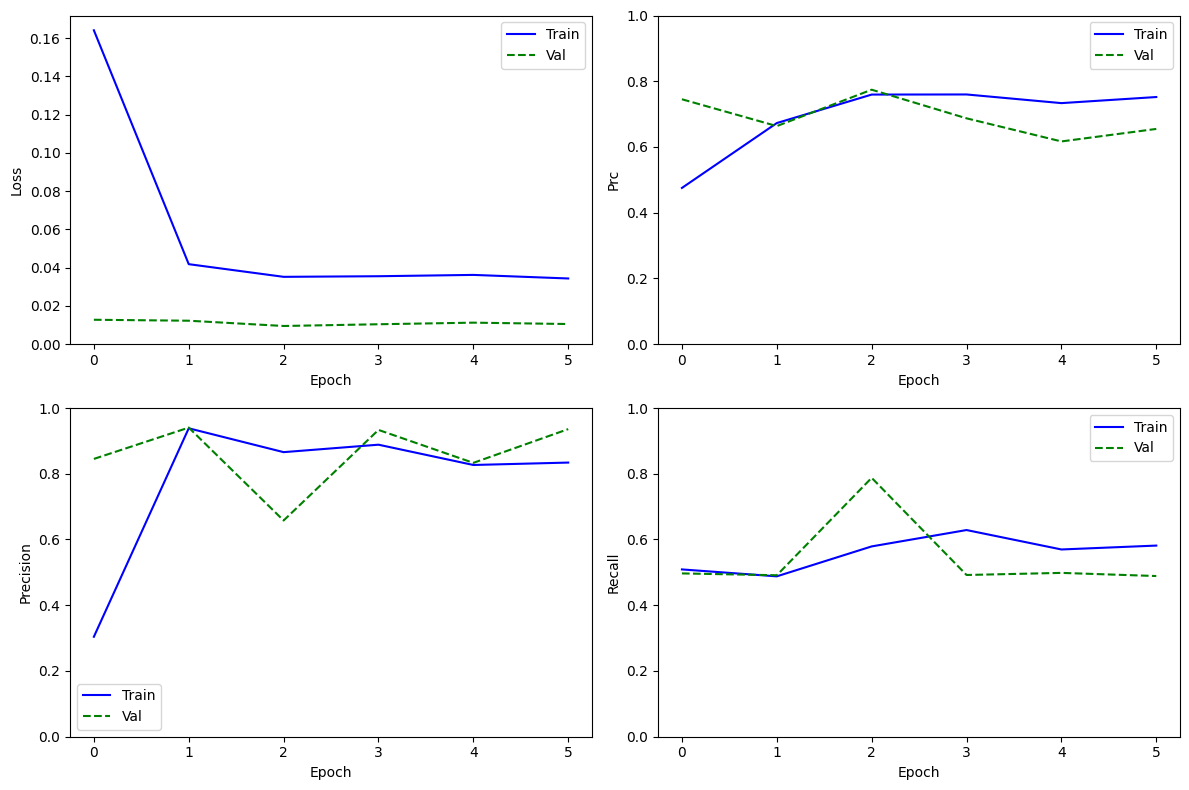

In [10]:
def plot_metrics(history, figsize=(12, 8), subplot_whspace=0.4, subplot_hspace=0.3):
    """
    Plots training and validation metrics from a Keras history object.

    Args:
      history: Keras history object containing training and validation metrics.
      figsize: Figure size (width, height) for the plot. Defaults to (12, 8).
      subplot_whspace: Horizontal spacing between subplots.
      subplot_hspace: Vertical spacing between subplots.
    """

    metrics = ['loss', 'prc', 'precision', 'recall']
    rows, cols = 2, 2

    plt.figure(figsize=figsize)
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        ax = plt.subplot(rows, cols, n+1)

        ax.plot(history.epoch, history.history[metric], color='b', label='Train')
        ax.plot(history.epoch, history.history['val_'+metric], color='g', linestyle='--', label='Val')

        ax.set_xlabel('Epoch')
        ax.set_ylabel(name)

        if metric == 'loss':
            ax.set_ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            ax.set_ylim([0.8, 1])
        else:
            ax.set_ylim([0, 1])

        ax.legend()

    plt.tight_layout()
    plt.show()
plot_metrics(baseline_history)

In [11]:
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

28/28 [==============================] - 1s 14ms/step


In [12]:
def plot_cm(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.00953227560967207
precision :  0.6577718257904053
recall :  0.7875399589538574
cross entropy :  0.009532276540994644
Brier score :  0.0019097551703453064
auc :  0.9446276426315308
prc :  0.7742526531219482

Legitimate Transactions Detected (True Negatives):  275709
Legitimate Transactions Incorrectly Detected (False Positives):  513
Fraudulent Transactions Missed (False Negatives):  266
Fraudulent Transactions Detected (True Positives):  986
Total Fraudulent Transactions:  1252


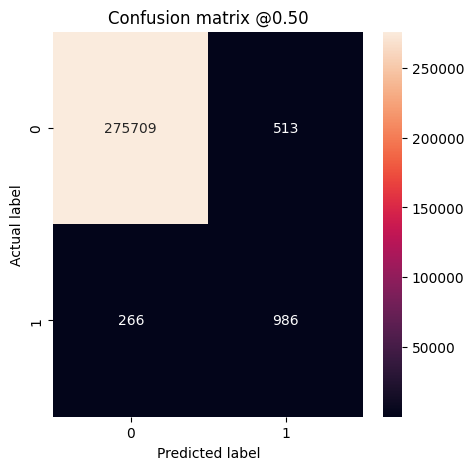

In [13]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

Legitimate Transactions Detected (True Negatives):  275710
Legitimate Transactions Incorrectly Detected (False Positives):  512
Fraudulent Transactions Missed (False Negatives):  266
Fraudulent Transactions Detected (True Positives):  986
Total Fraudulent Transactions:  1252
Legitimate Transactions Detected (True Negatives):  275314
Legitimate Transactions Incorrectly Detected (False Positives):  908
Fraudulent Transactions Missed (False Negatives):  210
Fraudulent Transactions Detected (True Positives):  1042
Total Fraudulent Transactions:  1252


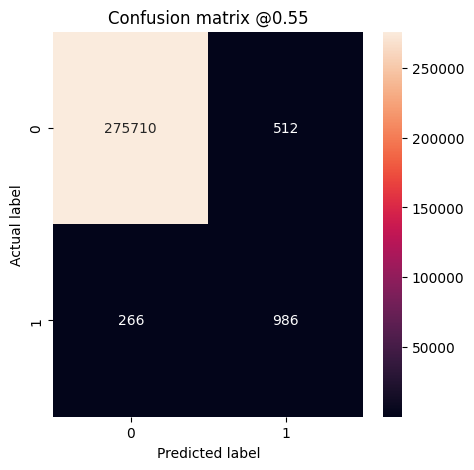

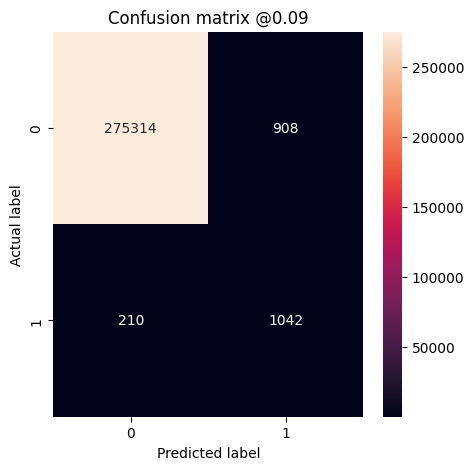

In [14]:
plot_cm(y_test, test_predictions_baseline, threshold=0.55)
plot_cm(y_test, test_predictions_baseline, threshold=0.09)

In [21]:
# filename = "model_lstm64_do25_lstm16_do5_batch10000.sav"
# pickle.dump(model, open(filename, 'wb'))

### Testing with new data

In [20]:
#function to preprocess file, takes a csv filepath as input
def preprocessingFile (filepath):
    #Read file and drop unrequired features
    df = pd.read_csv(filepath)
    
    #feature engineering
    df['nameDest_initial'] = df['nameDest'].astype(str).str[0]
    df['errorOrig'] = df['newBalanceOrig'] + df['amount'] - df['oldBalanceOrig']
    df['errorDest'] = df['oldBalanceDest'] + df['amount'] - df['newBalanceDest']
    
    
    df = df.drop(['nameOrig', 'nameDest','isFlaggedFraud','isUnauthorizedOverdraft'], axis=1)
    df = df[(df.action == 'TRANSFER') | (df.action == 'CASH_OUT')]
    

    columns_to_encode = ['action', 'nameDest_initial']

    # Binary encoding using pd.factorize
    df[columns_to_encode] = df[columns_to_encode].apply(lambda x: pd.factorize(x)[0])
    
    
    #Set up X and y
    y = df.isFraud 
    X = df.drop(['isFraud'], axis=1)
    
    X = X.to_numpy()
    
    #Reshape X to fit model
    X = X.reshape((X.shape[0], 1,X.shape[1]))
    
    #Return preprocessed features
    return X,y


#To get binary prediction
def getPrediction (X, model, threshold=0.5):
    predictions = model.predict(X)
    return predictions

#To load model using the given path
def loadModel(modelPath):
    loaded_model = pickle.load(open(modelPath, 'rb'))
    return loaded_model
   
# Calculates and prints scores   
def getScores(y, y_pred, threshold = 0.5):
    
    y_pred = np.where(y_pred >= threshold, 1, 0)
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y, y_pred)
    print('Accuracy: %f' % accuracy)
    
    # precision tp / (tp + fp)
    precision = precision_score(y, y_pred)
    print('Precision: %f' % precision)
    
    # recall: tp / (tp + fn)
    recall = recall_score(y, y_pred)
    print('Recall: %f' % recall)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y, y_pred)
    print('F1 score: %f' % f1)
    
    
#Main function which takes a csv file filepath and model file path
#Preprocess the input csv file and runs the prediction
#Prints scores and returns the predictions and actual y and X
def main(dataPath, modelPath):
    
    model = loadModel(modelPath)
    
    X,y = preprocessingFile(dataPath)
    
    predictions = getPrediction(X, model)

    return predictions,y,X

In [21]:
pred,actual,X = main('Dataset_2.csv', "model_lstm64_do25_lstm16_do5_batch10000.sav" )

31285/31285 [==============================] - 24s 758us/step


Legitimate Transactions Detected (True Negatives):  998623
Legitimate Transactions Incorrectly Detected (False Positives):  1002
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  1455
Total Fraudulent Transactions:  1464
Legitimate Transactions Detected (True Negatives):  998632
Legitimate Transactions Incorrectly Detected (False Positives):  993
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  1454
Total Fraudulent Transactions:  1464


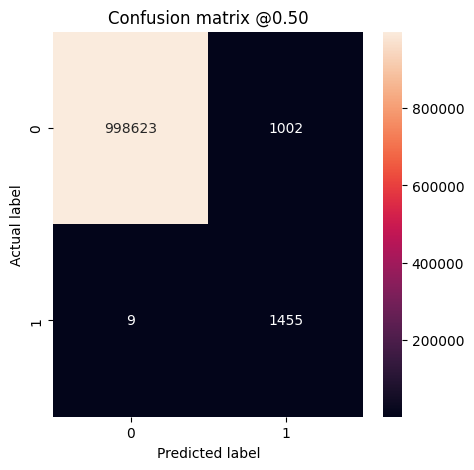

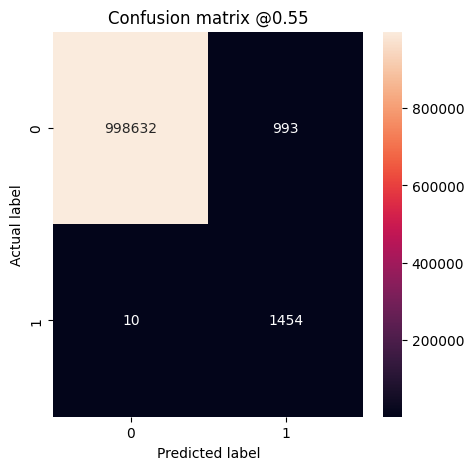

In [22]:
plot_cm(actual, pred)
plot_cm(actual, pred, 0.55)

In [23]:
getScores(actual,pred)

Accuracy: 0.998990
Precision: 0.592186
Recall: 0.993852
F1 score: 0.742158



My LSTM model for fraud detection is showing some promise, but it's not perfect yet. While it's great at catching almost all the bad guys (recall of 99.38%), it also throws a lot of innocent transactions into the mix (precision of 59.22%). It's like a super enthusiastic security guard catching everyone who looks suspicious, even if they just forgot their ID.

The good news is I can probably train it to be a bit more discerning. I can either tighten up its criteria to catch fewer good folks by mistake, or I can dig deeper into the false positives to understand why it's making those errors. With some adjustments, I think I can get this model to be both a fraud-fighting champion and a customer-friendly hero.